In [122]:
import numpy as np
from scipy.stats import norm, multivariate_normal

from utils import traceplot, acfplot, pairplot

# Hybrid Rosenbrock Direct Sampler


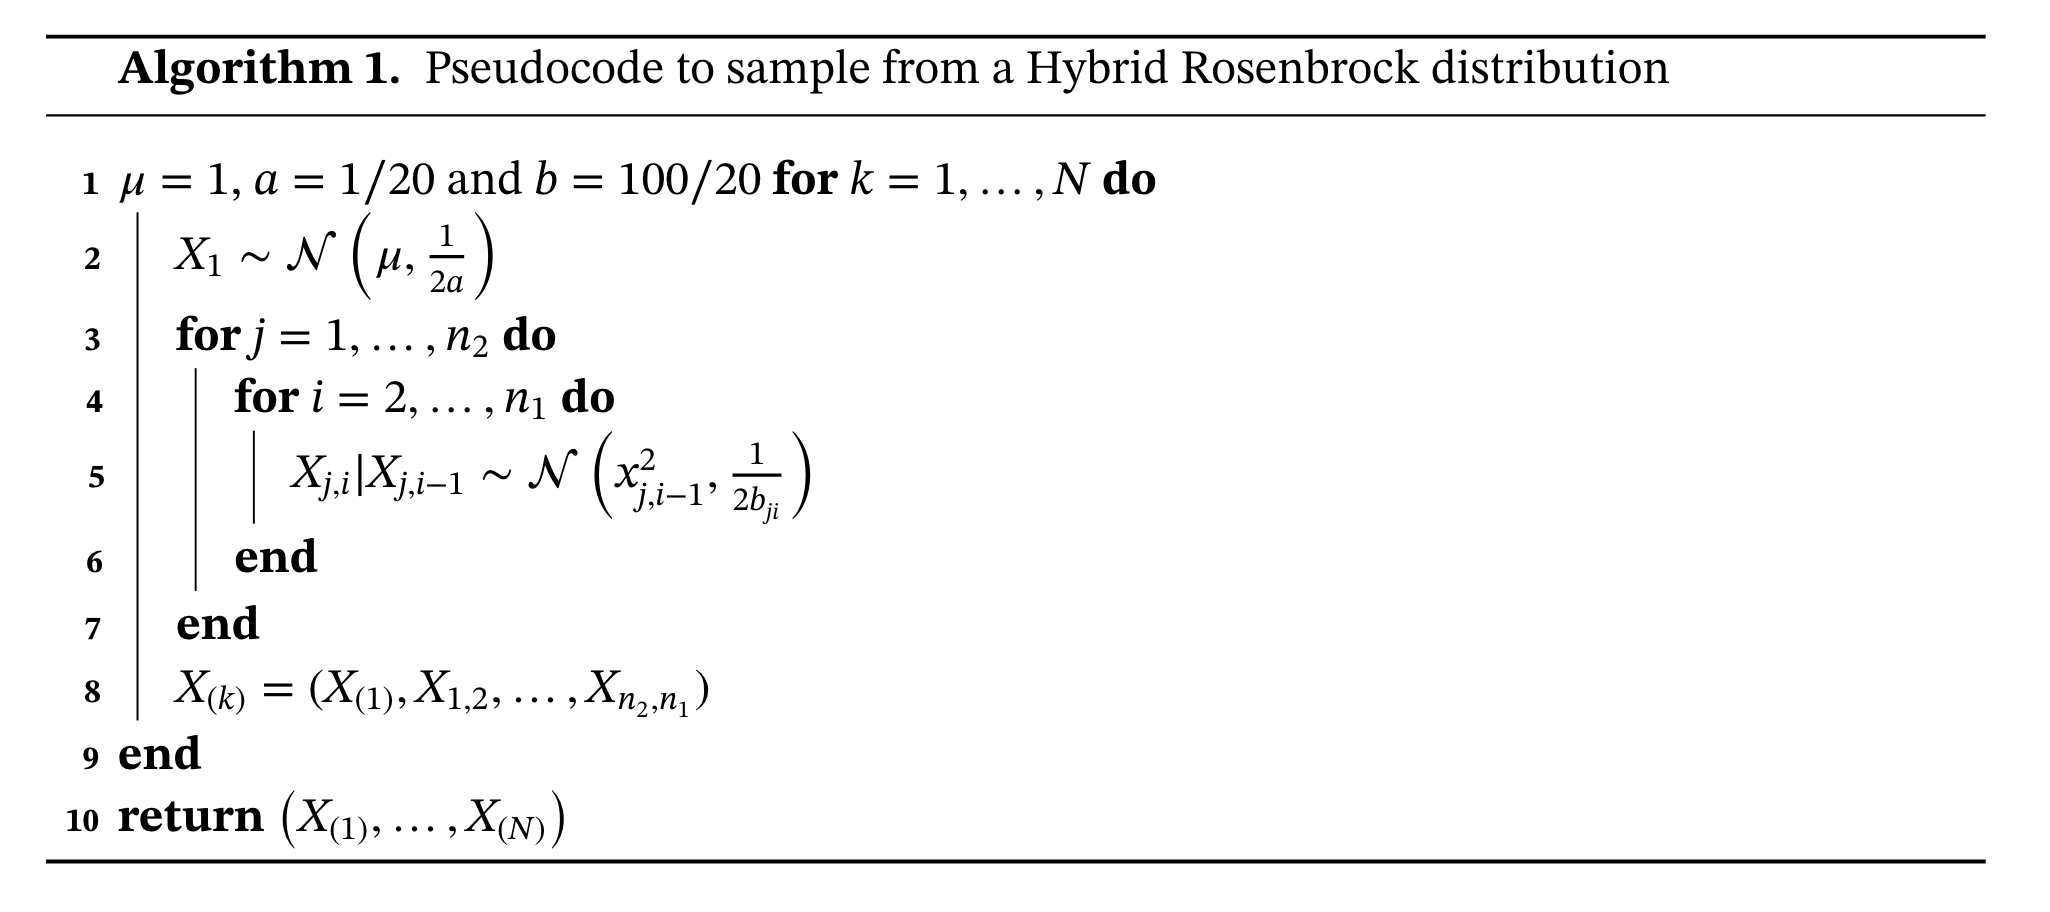


In [123]:
def sample_rosenbrock(n_iter, n1, n2, mu=1, a=0.05, b=5):
    n_dim = (n1 - 1) * n2 + 1

    X = np.empty((n_dim, n_iter))

    for t in range(n_iter):
        X[0, t] = np.random.normal(mu, 1/np.sqrt(2*a))

        for j in range(n2):
            for i in range(1, n1):
                idx = (n1-1) * j + i

                if i == 1:
                    x_parent = X[0, t]
                else:
                    x_parent = X[idx-1, t]

                X[idx, t] = np.random.normal(x_parent**2, 1/np.sqrt(2*b))
    
    return X

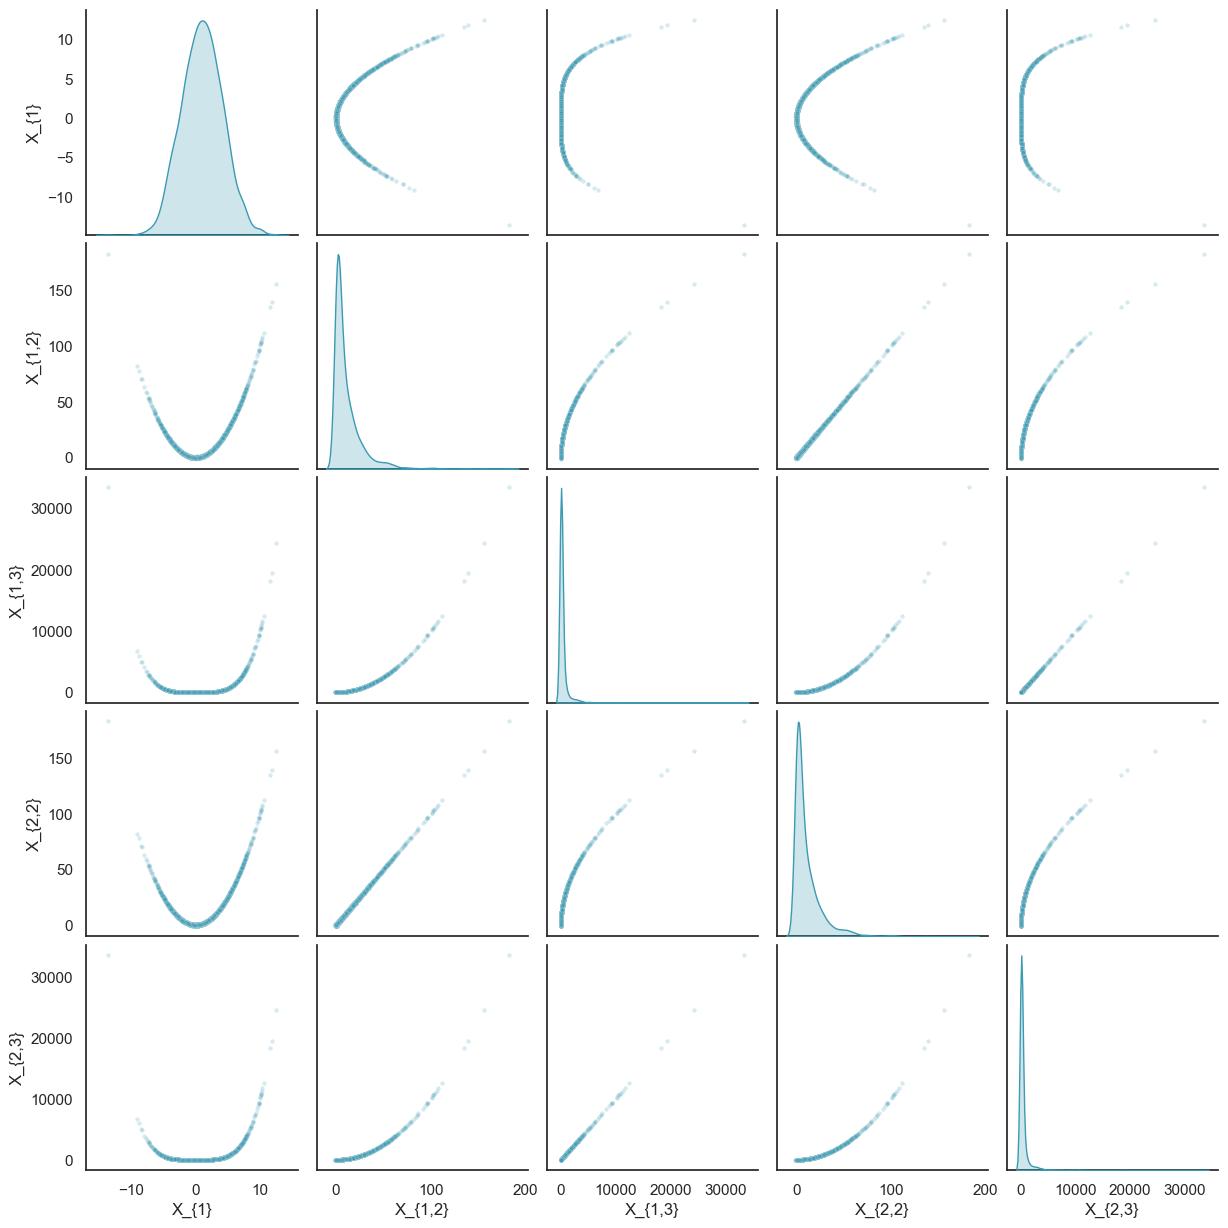

In [124]:
N1=3
N2=2

X_true = sample_rosenbrock(n_iter=3000, n1=N1, n2=N2)
pairplot(X_true, n1=N1, n2=N2)

# Hybrid Rosenbrock Kernel


**Kernel**

$$
\pi(\mathbf{x}) \propto \exp \left\{
-a(x_1 - \mu)^2
- \sum_{j=1}^{n_2} \sum_{i=2}^{n_1} b_{j,i} \left( x_{j,i} - x_{j,i-1}^2 \right)^2
\right\}
$$

**Log PDF**
$$\log\pi(\mathbf{x}) \propto - a \left(x_1 - \mu\right)^2 - \sum_{j=1}^{n_2} \sum_{i=2}^{n_1} b_{j,i} \left( x_{j,i} - x_{j,i-1}^2 \right)^2 $$


**First derivative of log PDF**

$$
\frac{\partial}{\partial x_{j,i}}\log\pi(\mathbf{x})
=
\begin{cases}
-\,2\,a\,\bigl(x_1 - \mu\bigr)
  \;+\;
  \displaystyle
  \sum_{j=1}^{n_{2}}
    4\,b_{j,2}\
      (x_{j,2} \;-\; 3\,x_1^{2})
& \quad i = 1
\\[1.2em]
-2\,b_{j,i}\, (x_{j,i} - x_{j,i-1}^{2})
   \;+\;
   4\,b_{j,i+1}\, (x_{j,i+1} - x_{j,i}^{2})\,x_{j,i}
& \quad 2 \le i < n_1
\\[1.2em]
-2\,b_{j,n_{1}}\,
   (x_{j,n_{1}} - x_{j,n_{1}-1}^{2})
& \quad i = n_1
\end{cases}
\quad
\text{for all } j = 1,\dots,n_{2}
$$


**Second derivative of log PDF**

$$
\begin{aligned}
%------------------------------------------------
% Second derivative wrt x_{j,i}^2
%------------------------------------------------
\frac{\partial^2}{\partial x_{j, i}^2}\,\log\pi(\mathbf{x})
&=
\begin{cases}
-\,2\,a
  \;+\;
  \displaystyle
  \sum_{j=1}^{n_{2}}
    4\,b_{j,2}\
      (x_{j,2} \;-\; 3\,x_1^{2})
& \quad i = 1
\\[1.2em]
-\,2\,b_{j,i}
  \;+\;
  4\,b_{j,i+1}\
    (x_{j,i+1} \;-\; 3\,x_{j,i}^{2})
& \quad 2 \le i < n_1
\\[1.2em]
-\,2\,b_{j,n_1}
& \quad i = n_1
\end{cases}
\\[1.2em]
%------------------------------------------------
% Cross partial derivative wrt x_{j,i} and x_{j,i'}
%------------------------------------------------
\frac{\partial^2}{\partial x_{j, i}\,\partial x_{j, i'}}\,\log\pi(\mathbf{x})
&=
\begin{cases}
4\,b_{j,i'}\,x_{j,i}
& \quad i' = i + 1
\\[1.2em]
0
& \quad \text{otherwise}
\end{cases}
\end{aligned}
$$


In [125]:
def _get_parents(x, n1, n2, mu):
    parents = np.zeros_like(x)

    # X_{1}
    parents[0] = np.sqrt(mu)

    # Default: each variable's parent is its previous
    parents[1:] = x[:-1]

    # X_{j, 2} special case for the start of each block
    for j in range(1, n2):
        parents[j * (n1-1) + 1] = x[0]

    return parents


def logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    parents = _get_parents(x, n1, n2, mu)

    return (- a * (x[0] - mu)**2) - (b * np.sum((x[1:] - parents[1:]**2)**2))


def partial_logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    partial_logpi = np.zeros_like(x)

    parents = _get_parents(x, n1, n2, mu)
    diff = x - parents**2

    # X_{1}
    partial_logpi[0] = (- 2 * a * diff[0]) + (4 * b * np.sum(diff[1::n1-1]) * x[0])

    # X_{j, i} for 2 <= i <= n1
    partial_logpi[1:] = - 2 * b * diff[1:]

    # X_{j, i} for 2 <= 1 < n1
    for j in range(n2):
        start = (n1 - 1) * j + 1
        stop = (n1 - 1) * (j + 1)
        partial_logpi[start:stop] += 4 * b * diff[start+1:stop+1] * x[start:stop]
    
    return partial_logpi


def hessian_logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    hessian_logpi = np.zeros((x.shape[0], x.shape[0]))

    parents = _get_parents(x, n1, n2, mu)
    diff = x - (3 * parents**2)

    # Diagonal entry for X_{1}
    hessian_logpi[0, 0] = (- 2 * a) + (4 * b * np.sum(diff[1::n1-1]))

    # Diagonal entries for X_{j, i} 2 <= i <= n1
    diag_idx = np.diag_indices_from(hessian_logpi)
    hessian_logpi[diag_idx[0][1:], diag_idx[1][1:]] = - 2 * b

    # Diagonal entries for X_{j, i} 2 <= i < n1
    for j in range (n2):
        start = (n1 - 1) * j + 1
        stop = (n1 - 1) * (j + 1)
        hessian_logpi[diag_idx[0][start:stop], diag_idx[1][start:stop]] += 4 * b * diff[start+1:stop+1] 
    
    # Off-diagonal entries
    for j in range(n2):
        for i in range(1, n1):
            idx = (n1-1) * j + i
            
            if i == 1:
                hessian_logpi[idx, 0] = 4 * b * x[0]
                hessian_logpi[0, idx] = hessian_logpi[idx, 0]
            else:
                hessian_logpi[idx, idx-1] = 4 * b * x[idx-1]
                hessian_logpi[idx-1, idx] = hessian_logpi[idx, idx-1]
    
    return hessian_logpi

# Experiment


In [126]:
from rosenbrock import SMMALA, SMBarker

Acceptance rate: 0.5752


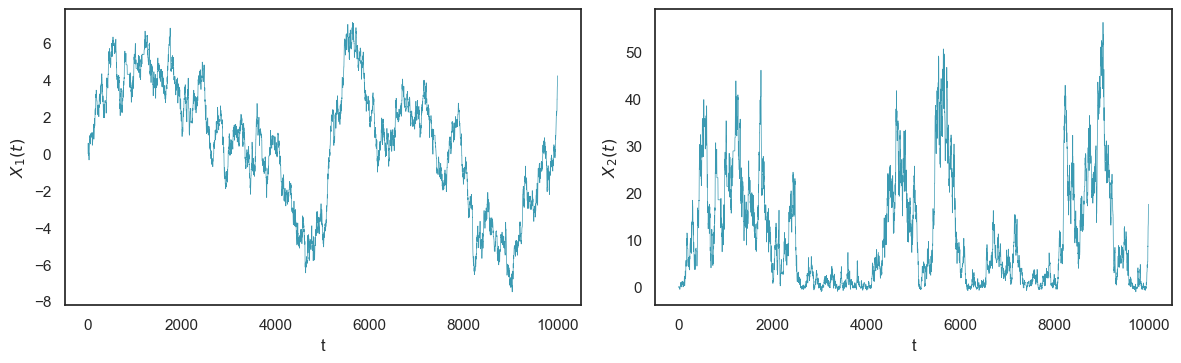

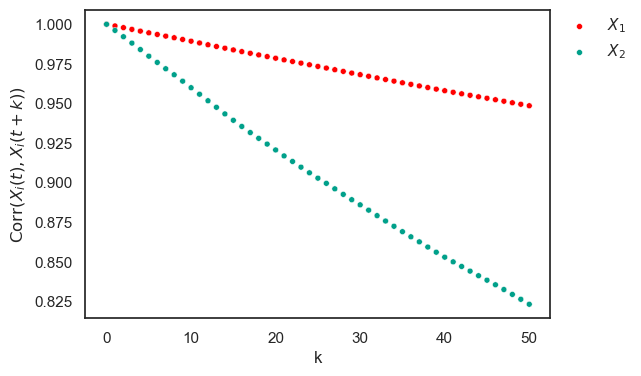

Acceptance rate: 0.5534


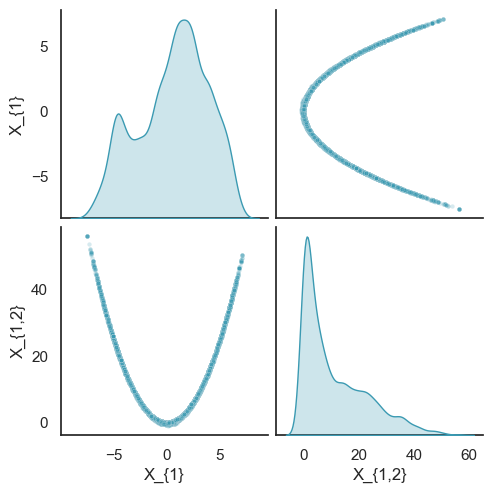

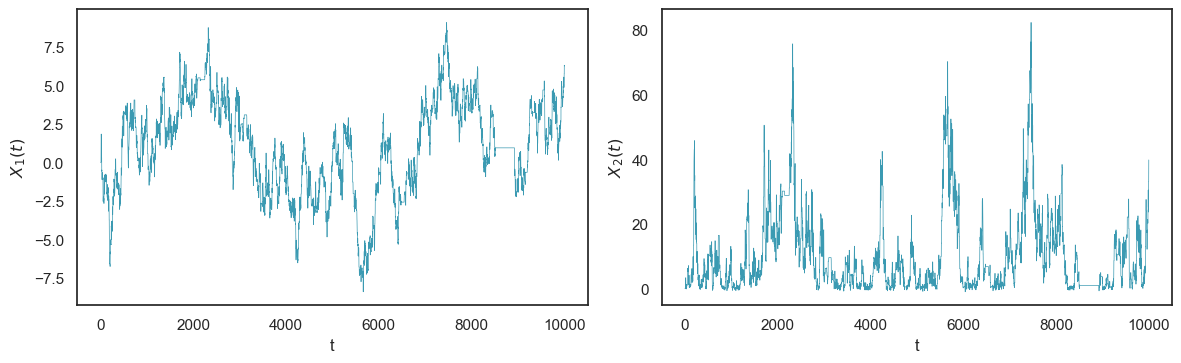

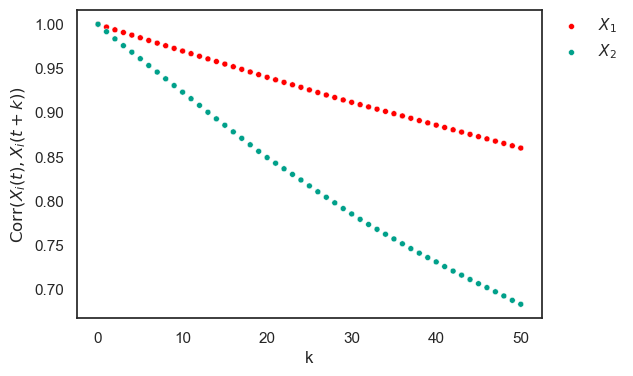

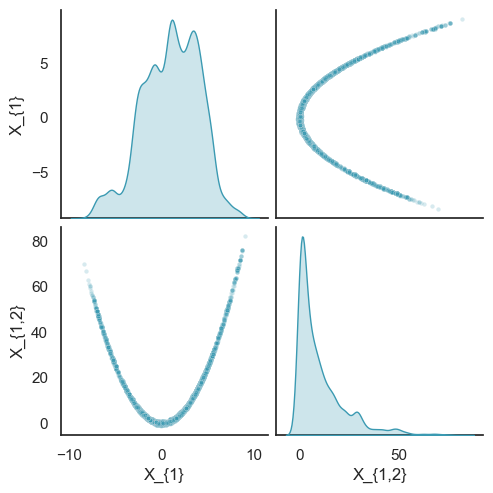

In [ ]:
# N1 = 2
# N2 = 1
# X_INIT = [0, 0]
# N_ITER = 10000

# X_smmala, accept_rate = SMMALA(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=0.6,
#     n1=N1,
#     n2=N2
# )

# print(f'Acceptance rate: {accept_rate}')
# traceplot(X_smmala, overlay=False)
# acfplot(X_smmala)
# pairplot(X_smmala, N1, N2)

# X_smbarker, accept_rate = SMBarker(
#     logpi=logpi_rosenbrock,
#     partial_logpi=partial_logpi_rosenbrock,
#     hessian_logpi=hessian_logpi_rosenbrock,
#     n_iter=N_ITER,
#     x_init=X_INIT,
#     step_size=1.45,
#     n1=N1,
#     n2=N2
# )

# print(f'Acceptance rate: {accept_rate}')
# traceplot(X_smbarker, overlay=False)
# acfplot(X_smbarker)
# pairplot(X_smbarker, N1, N2)